In [225]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

df = pd.read_csv("./data/Elspotprices.csv", sep=";")
df_load = pd.read_csv("./data/total_load.csv", sep=",")
df_gen = pd.read_csv("./data/generation_production.csv", sep=",")
df.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2024-04-13 21:00,2024-04-13 23:00,DK1,"52,590000","7,050000"
1,2024-04-13 20:00,2024-04-13 22:00,DK1,"153,679993","20,600000"
2,2024-04-13 19:00,2024-04-13 21:00,DK1,"258,500000","34,650002"
3,2024-04-13 18:00,2024-04-13 20:00,DK1,"298,630005","40,029999"
4,2024-04-13 17:00,2024-04-13 19:00,DK1,"373,760010","50,099998"


In [226]:
TRAIN_DAYS= 300 

df = df[['HourDK', 'SpotPriceEUR' ]]
df['HourDK'] = pd.to_datetime(df['HourDK'])
df = df[(df['HourDK'] >= '2023-01-01') & (df['HourDK'] <= '2023-12-31')]
df = df.iloc[::-1]
df['item_id'] = 'electricity_price'
df['SpotPriceEUR'] = df['SpotPriceEUR'].str.replace(',', '.').astype(float)
df_test = df.copy()
df = df.iloc[:TRAIN_DAYS*24 - 1]
df_test = df_test.iloc[((TRAIN_DAYS-5)*24) -1:(TRAIN_DAYS+1)*24 -1]
df.head()


,HourDK,SpotPriceEUR,item_id
11254,2023-01-01 00:00:00,2.01,electricity_price
11253,2023-01-01 01:00:00,1.38,electricity_price
11252,2023-01-01 02:00:00,0.09,electricity_price
11251,2023-01-01 03:00:00,0.08,electricity_price
11250,2023-01-01 04:00:00,0.05,electricity_price


In [227]:
# Process the generation data
# Extract the date and time from MTU column
df_gen['MTU'] = df_gen['MTU'].str.split(' - ').str[0]
df_gen['MTU'] = pd.to_datetime(df_gen['MTU'], format='%d.%m.%Y %H:%M')
df_gen = df_gen.rename(columns={'MTU': 'HourDK'})

keep_names = [  'Biomass - Actual Aggregated [MW]', 'Fossil Gas - Actual Aggregated [MW]', 'Fossil Hard coal - Actual Aggregated [MW]', 
                'Fossil Oil - Actual Aggregated [MW]', 'Solar - Actual Aggregated [MW]', 'Waste - Actual Aggregated [MW]', 'Wind Offshore - Actual Aggregated [MW]', 
                'Wind Onshore - Actual Aggregated [MW]'
             ]

df_gen = df_gen[['HourDK', *keep_names]]

# Add item_id column
df_gen['item_id'] = 'electricity_generation'
# Create train and test sets
df_gen_test = df_gen.copy()
df_gen = df_gen.iloc[:TRAIN_DAYS*24]
df_gen_test = df_gen_test.iloc[((TRAIN_DAYS-5)*24):(TRAIN_DAYS+1)*24]

# Display the first few rows
df_gen.head()


,HourDK,Biomass - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW],item_id
0,2023-01-01 00:00:00,138.0,77.0,148.0,9.0,0.0,69.0,187.0,523.0,electricity_generation
1,2023-01-01 01:00:00,166.0,76.0,147.0,9.0,0.0,69.0,351.0,782.0,electricity_generation
2,2023-01-01 02:00:00,223.0,81.0,148.0,9.0,0.0,69.0,315.0,834.0,electricity_generation
3,2023-01-01 03:00:00,256.0,81.0,148.0,9.0,0.0,69.0,303.0,855.0,electricity_generation
4,2023-01-01 04:00:00,240.0,78.0,148.0,9.0,0.0,69.0,214.0,916.0,electricity_generation


In [228]:

# Process the load data
df_load['Time (CET/CEST)'] = df_load['Time (CET/CEST)'].str.split(' - ').str[0]
df_load['Time (CET/CEST)'] = pd.to_datetime(df_load['Time (CET/CEST)'], format='%d.%m.%Y %H:%M')
df_load = df_load[['Time (CET/CEST)', 'Actual Total Load [MW] - BZN|DK1']]
df_load = df_load.rename(columns={'Time (CET/CEST)': 'timestamp', 'Actual Total Load [MW] - BZN|DK1': 'load'})

# Add item_id column
df_load['item_id'] = 'electricity_load'

# Create train and test sets
df_load_test = df_load.copy()
df_load = df_load.iloc[:TRAIN_DAYS*24]
df_load_test = df_load_test.iloc[((TRAIN_DAYS-5)*24):(TRAIN_DAYS+1)*24]

# Print first and last dates for df and df_load
print("DataFrame df date range:")
print(f"First date: {df['HourDK'].min()}")
print(f"Last date: {df['HourDK'].max()}")
print("\nDataFrame df_load date range:")
print(f"First date: {df_load['timestamp'].min()}")
print(f"Last date: {df_load['timestamp'].max()}")
# Print date range for df_gen and df_gen_test
print("\nDataFrame df_gen date range:")
print(f"First date: {df_gen['HourDK'].min()}")
print(f"Last date: {df_gen['HourDK'].max()}")
print("\nDataFrame df_gen_test date range:")
print(f"First date: {df_gen_test['HourDK'].min()}")
print(f"Last date: {df_gen_test['HourDK'].max()}")


# Print first and last dates for df_test and df_load_test
print("\nDataFrame df_test date range:")
print(f"First date: {df_test['HourDK'].min()}")
print(f"Last date: {df_test['HourDK'].max()}")
print("\nDataFrame df_load_test date range:")
print(f"First date: {df_load_test['timestamp'].min()}")
print(f"Last date: {df_load_test['timestamp'].max()}")


DataFrame df date range:
First date: 2023-01-01 00:00:00
Last date: 2023-10-27 23:00:00

DataFrame df_load date range:
First date: 2023-01-01 00:00:00
Last date: 2023-10-27 23:00:00

DataFrame df_gen date range:
First date: 2023-01-01 00:00:00
Last date: 2023-10-27 23:00:00

DataFrame df_gen_test date range:
First date: 2023-10-23 00:00:00
Last date: 2023-10-28 23:00:00

DataFrame df_test date range:
First date: 2023-10-23 00:00:00
Last date: 2023-10-28 23:00:00

DataFrame df_load_test date range:
First date: 2023-10-23 00:00:00
Last date: 2023-10-28 23:00:00


In [229]:
# Check for missing timestamps in df and df_load
print(f"df shape: {df.shape}")
print(f"df_load shape: {df_load.shape}")

# Ensure timestamps are aligned between df and df_load
# Convert timestamp column in df_load to match HourDK format in df
df_load['timestamp'] = pd.to_datetime(df_load['timestamp'])

# Check if there are any missing timestamps in df
df_hourly_range = pd.date_range(start=df['HourDK'].min(), end=df['HourDK'].max(), freq='H')
missing_hours_df = set(df_hourly_range) - set(df['HourDK'])
print(f"Missing hours in df: {len(missing_hours_df)}")
if missing_hours_df:
    print(f"Example missing hours: {list(missing_hours_df)[:5]}")

# Check if there are any missing timestamps in df_load
df_load_hourly_range = pd.date_range(start=df_load['timestamp'].min(), end=df_load['timestamp'].max(), freq='H')
missing_hours_df_load = set(df_load_hourly_range) - set(df_load['timestamp'])
print(f"Missing hours in df_load: {len(missing_hours_df_load)}")
if missing_hours_df_load:
    print(f"Example missing hours: {list(missing_hours_df_load)[:5]}")

# Fix the issue by reindexing df to ensure it has all hourly timestamps
if len(missing_hours_df) > 0:
    # Create a complete hourly index
    full_range = pd.date_range(start=df['HourDK'].min(), end=df['HourDK'].max(), freq='H')
    
    # Create a template dataframe with all hours
    template_df = pd.DataFrame({'HourDK': full_range})
    
    # Merge with original df to fill in missing hours
    df = pd.merge(template_df, df, on='HourDK', how='left')
    
    # Fill missing values (if any)
    df['item_id'] = df['item_id'].fillna('electricity_price')
    # Forward fill or interpolate price values as appropriate
    df['SpotPriceEUR'] = df['SpotPriceEUR'].interpolate(method='linear')
    
    print(f"Fixed df shape: {df.shape}")
# Ensure both dataframes have the same number of rows
print(f"Final df shape: {df.shape}")
print(f"Final df_load shape: {df_load.shape}")


df shape: (7199, 3)
df_load shape: (7200, 3)
Missing hours in df: 1
Example missing hours: [Timestamp('2023-03-26 02:00:00')]
Missing hours in df_load: 0
Fixed df shape: (7200, 3)
Final df shape: (7200, 3)
Final df_load shape: (7200, 3)


C:\Users\marchesi\AppData\Local\Temp\ipykernel_3908\1634638012.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly_range = pd.date_range(start=df['HourDK'].min(), end=df['HourDK'].max(), freq='H')
C:\Users\marchesi\AppData\Local\Temp\ipykernel_3908\1634638012.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_load_hourly_range = pd.date_range(start=df_load['timestamp'].min(), end=df_load['timestamp'].max(), freq='H')
C:\Users\marchesi\AppData\Local\Temp\ipykernel_3908\1634638012.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df['HourDK'].min(), end=df['HourDK'].max(), freq='H')


In [230]:
df = df.assign(load=df_load['load'].values)

# Add all the columns from keep_names to df
for column in keep_names:
    if column in df_gen.columns:
        df[column] = df_gen[column].values

df_test = df_test.assign(load=df_load_test['load'].values)
for column in keep_names:
    if column in df_gen_test.columns:
        df_test[column] = df_gen_test[column].values

df_test.tail()

,HourDK,SpotPriceEUR,item_id,load,Biomass - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW]
4036,2023-10-28 19:00:00,92.379997,electricity_price,2538.0,245.0,136.0,278.0,15.0,0.0,53.0,1135.0,1636.0
4035,2023-10-28 20:00:00,68.790001,electricity_price,2445.0,246.0,119.0,195.0,15.0,0.0,47.0,1159.0,1745.0
4034,2023-10-28 21:00:00,61.910000,electricity_price,2341.0,145.0,95.0,171.0,12.0,0.0,35.0,1173.0,1878.0
4033,2023-10-28 22:00:00,58.540001,electricity_price,2279.0,17.0,94.0,164.0,11.0,0.0,35.0,1188.0,2019.0
4032,2023-10-28 23:00:00,47.480000,electricity_price,2241.0,11.0,92.0,145.0,12.0,0.0,34.0,1192.0,2111.0


In [238]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="HourDK",
)
test_data = TimeSeriesDataFrame.from_data_frame(
    df_test,
    id_column="item_id",
    timestamp_column="HourDK",
)

train_data.head()

SpotPriceEUR    load  \
item_id           timestamp                                   
electricity_price 2023-01-01 00:00:00          2.01  2158.0   
                  2023-01-01 01:00:00          1.38  2123.0   
                  2023-01-01 02:00:00          0.09  2128.0   
                  2023-01-01 03:00:00          0.08  2026.0   
                  2023-01-01 04:00:00          0.05  1986.0   

                                       Biomass - Actual Aggregated [MW]  \
item_id           timestamp                                               
electricity_price 2023-01-01 00:00:00                             138.0   
                  2023-01-01 01:00:00                             166.0   
                  2023-01-01 02:00:00                             223.0   
                  2023-01-01 03:00:00                             256.0   
                  2023-01-01 04:00:00                             240.0   

                                       Fossil Gas - Actual Aggregated [MW]  \
item_id           timestamp                                                  
electricity_price 2023-01-01 00:00:00                                 77.0   
                  2023-01-01 01:00:00                                 76.0   
                  2023-01-01 02:00:00                                 81.0   
                  2023-01-01 03:00:00                                 81.0   
                  2023-01-01 04:00:00                                 78.0   

                                       Fossil Hard coal - Actual Aggregated [MW]  \
item_id           timestamp                                                        
electricity_price 2023-01-01 00:00:00                                      148.0   
                  2023-01-01 01:00:00                                      147.0   
                  2023-01-01 02:00:00                                      148.0   
                  2023-01-01 03:00:00                                      148.0   
                  2023-01-01 04:00:00                                      148.0   

                                       Fossil Oil - Actual Aggregated [MW]  \
item_id           timestamp                                                  
electricity_price 2023-01-01 00:00:00                                  9.0   
                  2023-01-01 01:00:00                                  9.0   
                  2023-01-01 02:00:00                                  9.0   
                  2023-01-01 03:00:00                                  9.0   
                  2023-01-01 04:00:00                                  9.0   

                                       Solar - Actual Aggregated [MW]  \
item_id           timestamp                                             
electricity_price 2023-01-01 00:00:00                             0.0   
                  2023-01-01 01:00:00                             0.0   
                  2023-01-01 02:00:00                             0.0   
                  2023-01-01 03:00:00                             0.0   
                  2023-01-01 04:00:00                             0.0   

                                       Waste - Actual Aggregated [MW]  \
item_id           timestamp                                             
electricity_price 2023-01-01 00:00:00                            69.0   
                  2023-01-01 01:00:00                            69.0   
                  2023-01-01 02:00:00                            69.0   
                  2023-01-01 03:00:00                            69.0   
                  2023-01-01 04:00:00                            69.0   

                                       Wind Offshore - Actual Aggregated [MW]  \
item_id           timestamp                                                     
electricity_price 2023-01-01 00:00:00                                   187.0   
                  2023-01-01 01:00:00                                   351.0   
                  2023-01-01 02:00:00   

In [232]:
predictor = TimeSeriesPredictor(
    prediction_length=24,
    path="autogluon-m4-hourly",
    target="SpotPriceEUR",
    eval_metric="MASE",
    freq="h",
)

predictor.fit(
    train_data,
    presets="high_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\energy_price_forecasting\autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       2.52 GB / 15.73 GB (16.0%)
Disk Space Avail:   265.79 GB / 456.62 GB (58.2%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'SpotPriceEUR',
 'time_limit': 600,
 'verbosity': 2}

Provided train_data has 7200 rows, 1 time series. Median time series lengt

In [233]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2  \
item_id           timestamp                                              
electricity_price 2023-10-28 00:00:00  94.670235  83.504378  87.648502   
                  2023-10-28 01:00:00  91.934135  76.158577  82.000463   
                  2023-10-28 02:00:00  86.225709  66.611679  73.848851   
                  2023-10-28 03:00:00  85.851619  62.865730  71.264355   
                  2023-10-28 04:00:00  89.001873  62.039219  71.841633   

                                             0.3        0.4        0.5  \
item_id           timestamp                                              
electricity_price 2023-10-28 00:00:00  90.396453  92.623484  94.670235   
                  2023-10-28 01:00:00  85.877265  89.037267  91.934135   
                  2023-10-28 02:00:00  78.657802  82.609732  86.225709   
                  2023-10-28 03:00:00  76.934965  81.588105  85.851619   
                  2023-10-28 04:00:00  78.490209  83.969118  89.001873   

                                             0.6        0.7         0.8  \
item_id           timestamp                                               
electricity_price 2023-10-28 00:00:00  96.704621  98.946353  101.683757   
                  2023-10-28 01:00:00  94.819512  97.969456  101.816376   
                  2023-10-28 02:00:00  89.837897  93.750080   98.526848   
                  2023-10-28 03:00:00  90.091484  94.681813  100.268153   
                  2023-10-28 04:00:00  93.999499  99.407739  105.970453   

                                              0.9  
item_id           timestamp                        
electricity_price 2023-10-28 00:00:00  105.785428  
                  2023-10-28 01:00:00  107.544920  
                  2023-10-28 02:00:00  105.618375  
                  2023-10-28 03:00:00  108.571912  
                  2023-10-28 04:00:00  115.692470

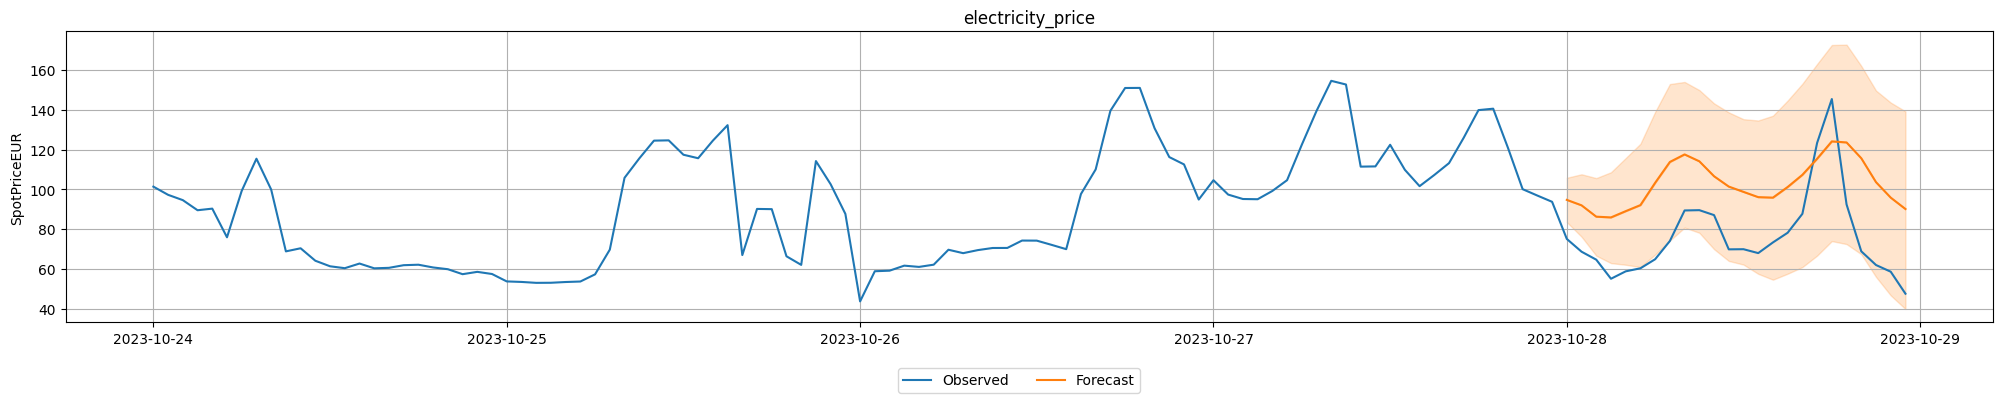

In [234]:
import matplotlib.pyplot as plt
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=24*5, max_num_item_ids=4)

In [235]:
# The test score is computed using the last
# prediction_length=24 timesteps of each time series in test_data
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,DynamicOptimizedTheta,-0.546329,-1.021504,28.721125,30.139997,0.021275,5
1,RecursiveTabular,-0.572381,-0.469239,1.128584,0.682503,1.894329,2
2,AutoETS,-0.624635,-0.653132,5.270061,3.840762,0.022237,6
3,TemporalFusionTransformer,-0.700828,-0.500770,0.097523,0.038187,99.962794,8
4,DirectTabular,-0.712416,-1.590467,0.204446,0.182421,1.652728,3
5,NPTS,-0.742023,-1.070226,2.714979,2.459141,0.018080,4
6,ChronosZeroShot[bolt_base],-0.785675,-0.497454,1.471723,2.743956,0.029561,7
7,WeightedEnsemble,-0.824258,-0.299711,2.624521,3.463663,0.397048,12
8,TiDE,-0.834831,-0.513772,0.099962,0.015715,136.085196,11
9,PatchTST,-0.878107,-0.323789,0.024213,0.037204,48.719976,10


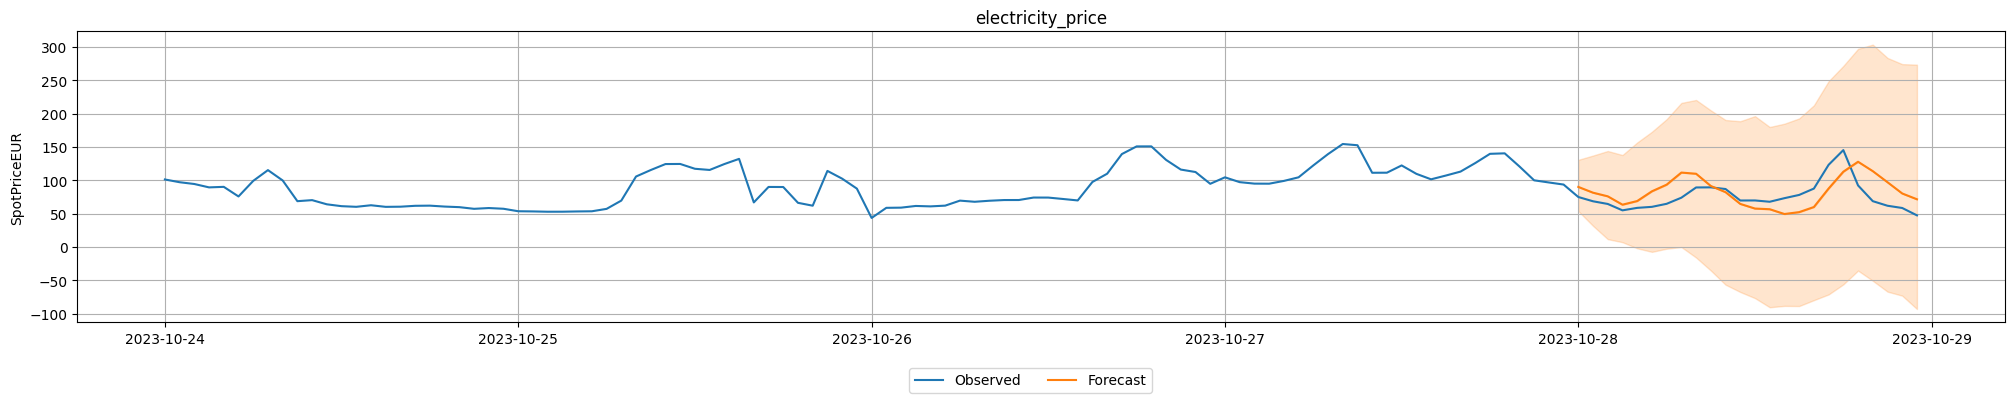

In [237]:
predictions = predictor.predict(train_data, model='RecursiveTabular')
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=24*5, max_num_item_ids=4)